In [3]:
import os
import cv2
from glob import glob
from tqdm import tqdm
import multiprocessing as mp
# from pydicom import dcmread
# import dicomsdl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob

In [4]:
for fold in range(0, 2):
    print(fold)

0
1


In [5]:
# external_data = pd.read_csv('external_data/external_data_path.csv')['dcm_filepath'].values.tolist()
external_data_paths = glob("input_data/train_external_data/*/*.png")
train_img_dcm = glob("input_data/train_images/*/*.dcm")

# valid_img_paths = glob("input/final_data/ultramnist4x4/val/*/*.jpeg")

In [165]:
nres = (1024,512)
npath = f"input_data/train_external{nres[0]}x{nres[1]}"
os.makedirs(f"{npath}", exist_ok=True)

In [8]:
npath = f"input_data/train_image_dcm_converted"
os.makedirs(f"{npath}", exist_ok=True)

In [2]:
LOAD_PRETRAINED = {
                  'fold-0': f'PATH/checkpoint-fold-0_ddp_ep_0_model.bin',
                  'fold-1': f'PATH/checkpoint-fold-1_ddp_ep_0_model.bin',
                  'fold-2': f'PAT/checkpoint-fold-2_ddp_ep_0_model.bin',
                  'fold-3': f'PATH/checkpoint-fold-3_ddp_ep_0_model.bin',
                  'fold-4': f'PATH/checkpoint-fold-4_ddp_ep_0_model.bin',
                    }

In [3]:
LOAD_PRETRAINED[f'fold-{1}']

'PATH/checkpoint-fold-1_ddp_ep_0_model.bin'

In [12]:
def img_resize(path):
    path_split = path.split("/")
    image = cv2.imread(path)
    image = cv2.resize(image, (nres[1], nres[0]), interpolation = cv2.INTER_NEAREST)
    save_path = os.path.join(npath, path_split[-2])
    os.makedirs(save_path, exist_ok=True)
    cv2.imwrite(os.path.join(save_path, path_split[-1]), image)
    

def dcm_load(path):
    path_split = path.split("/")
    data = dcmread(path)
    img = data.pixel_array
    img = (img - img.min()) /(img.max() - img.min())
    if data.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
    img *= 255
    img = np.uint8(img)
    save_path = os.path.join(npath, path_split[-2])
    
    
    os.makedirs(save_path, exist_ok=True)
    cv2.imwrite(os.path.join(save_path, f"{path_split[-1].split('.')[0]}.png"), img)    
    

In [56]:
with mp.Pool(72) as p:
    out = list(tqdm(p.imap(img_resize, train_img_paths), total=len(train_img_paths)))

100%|██████████| 54706/54706 [17:49<00:00, 51.15it/s] 


In [167]:
with mp.Pool(72) as p:
    out = list(tqdm(p.imap(img_resize, external_data_paths), total=len(external_data_paths)))

100%|██████████| 1374/1374 [00:15<00:00, 90.19it/s] 


In [13]:
with mp.Pool(74) as p:
    out = list(tqdm(p.imap(dcm_load, train_img_dcm), total=len(train_img_dcm)))

100%|██████████| 54706/54706 [1:43:05<00:00,  8.84it/s]  


## Apply VOI LUT

In [74]:
# import nvjpeg2k
import pandas as pd
import numpy as np
import cv2

from timeit import default_timer as timer
from joblib import Parallel, delayed
from glob import glob
##from tqdm import tqdm
from tqdm.notebook import tqdm


import pydicom

import dicomsdl


###########################################################################################
#from pydicom.pixel_data_handlers.util import apply_voi_lut

from typing import (
    Dict, Optional, Union, List, Tuple, TYPE_CHECKING, cast, Iterable,
    ByteString
)
from pydicom.valuerep import VR

def apply_voi_lut(
    arr: "np.ndarray",
    ds: "Dataset",
    index: int = 0,
    prefer_lut: bool = True
) -> "np.ndarray":
    """Apply a VOI lookup table or windowing operation to `arr`.

    .. versionadded:: 1.4

    .. versionchanged:: 2.1

        Added the `prefer_lut` keyword parameter

    Parameters
    ----------
    arr : numpy.ndarray
        The :class:`~numpy.ndarray` to apply the VOI LUT or windowing operation
        to.
    ds : dataset.Dataset
        A dataset containing a :dcm:`VOI LUT Module<part03/sect_C.11.2.html>`.
        If (0028,3010) *VOI LUT Sequence* is present then returns an array
        of ``np.uint8`` or ``np.uint16``, depending on the 3rd value of
        (0028,3002) *LUT Descriptor*. If (0028,1050) *Window Center* and
        (0028,1051) *Window Width* are present then returns an array of
        ``np.float64``. If neither are present then `arr` will be returned
        unchanged.
    index : int, optional
        When the VOI LUT Module contains multiple alternative views, this is
        the index of the view to return (default ``0``).
    prefer_lut : bool
        When the VOI LUT Module contains both *Window Width*/*Window Center*
        and *VOI LUT Sequence*, if ``True`` (default) then apply the VOI LUT,
        otherwise apply the windowing operation.

    Returns
    -------
    numpy.ndarray
        An array with applied VOI LUT or windowing operation.

    Notes
    -----
    When the dataset requires a modality LUT or rescale operation as part of
    the Modality LUT module then that must be applied before any windowing
    operation.

    See Also
    --------
    :func:`~pydicom.pixel_data_handlers.util.apply_modality_lut`
    :func:`~pydicom.pixel_data_handlers.util.apply_voi`
    :func:`~pydicom.pixel_data_handlers.util.apply_windowing`

    References
    ----------
    * DICOM Standard, Part 3, :dcm:`Annex C.11.2
      <part03/sect_C.11.html#sect_C.11.2>`
    * DICOM Standard, Part 3, :dcm:`Annex C.8.11.3.1.5
      <part03/sect_C.8.11.3.html#sect_C.8.11.3.1.5>`
    * DICOM Standard, Part 4, :dcm:`Annex N.2.1.1
      <part04/sect_N.2.html#sect_N.2.1.1>`
    """
    valid_voi = False
    if ds.get('VOILUTSequence'):
        ds.VOILUTSequence = cast(List["Dataset"], ds.VOILUTSequence)
        valid_voi = None not in [
            ds.VOILUTSequence[0].get('LUTDescriptor', None),
            ds.VOILUTSequence[0].get('LUTData', None)
        ]
    valid_windowing = None not in [
        ds.get('WindowCenter', None),
        ds.get('WindowWidth', None)
    ]

    if valid_voi and valid_windowing:
        if prefer_lut:
            return apply_voi(arr, ds, index)

        return apply_windowing(arr, ds, index)

    if valid_voi:
        return apply_voi(arr, ds, index)

    if valid_windowing:
        return apply_windowing(arr, ds, index)

    return arr


def apply_voi(
    arr: "np.ndarray", ds: "Dataset", index: int = 0
) -> "np.ndarray":
    """Apply a VOI lookup table to `arr`.

    .. versionadded:: 2.1

    Parameters
    ----------
    arr : numpy.ndarray
        The :class:`~numpy.ndarray` to apply the VOI LUT to.
    ds : dataset.Dataset
        A dataset containing a :dcm:`VOI LUT Module<part03/sect_C.11.2.html>`.
        If (0028,3010) *VOI LUT Sequence* is present then returns an array
        of ``np.uint8`` or ``np.uint16``, depending on the 3rd value of
        (0028,3002) *LUT Descriptor*, otherwise `arr` will be returned
        unchanged.
    index : int, optional
        When the VOI LUT Module contains multiple alternative views, this is
        the index of the view to return (default ``0``).

    Returns
    -------
    numpy.ndarray
        An array with applied VOI LUT.

    See Also
    --------
    :func:`~pydicom.pixel_data_handlers.util.apply_modality_lut`
    :func:`~pydicom.pixel_data_handlers.util.apply_windowing`

    References
    ----------
    * DICOM Standard, Part 3, :dcm:`Annex C.11.2
      <part03/sect_C.11.html#sect_C.11.2>`
    * DICOM Standard, Part 3, :dcm:`Annex C.8.11.3.1.5
      <part03/sect_C.8.11.3.html#sect_C.8.11.3.1.5>`
    * DICOM Standard, Part 4, :dcm:`Annex N.2.1.1
      <part04/sect_N.2.html#sect_N.2.1.1>`
    """
    if not ds.get('VOILUTSequence'):
        return arr

    if not np.issubdtype(arr.dtype, np.integer):
        print(#warnings.warn
            "Applying a VOI LUT on a float input array may give "
            "incorrect results"
        )

    # VOI LUT Sequence contains one or more items
    item = cast(List["Dataset"], ds.VOILUTSequence)[index]
    lut_descriptor = cast(List[int], item.LUTDescriptor)
    nr_entries = lut_descriptor[0] or 2**16
    first_map = lut_descriptor[1]

    # PS3.3 C.8.11.3.1.5: may be 8, 10-16
    nominal_depth = lut_descriptor[2]
    if nominal_depth in list(range(10, 17)):
        dtype = 'uint16'
    elif nominal_depth == 8:
        dtype = 'uint8'
    else:
        raise NotImplementedError(
            f"'{nominal_depth}' bits per LUT entry is not supported"
        )

    # Ambiguous VR, US or OW
    unc_data: Iterable[int]
    if item['LUTData'].VR == VR.OW:
        endianness = '<' if ds.is_little_endian else '>'
        unpack_fmt = f'{endianness}{nr_entries}H'
        unc_data = unpack(unpack_fmt, cast(bytes, item.LUTData))
    else:
        unc_data = cast(List[int], item.LUTData)

    lut_data: "np.ndarray" = np.asarray(unc_data, dtype=dtype)

    # IVs < `first_map` get set to first LUT entry (i.e. index 0)
    clipped_iv = np.zeros(arr.shape, dtype=dtype)
    # IVs >= `first_map` are mapped by the VOI LUT
    # `first_map` may be negative, positive or 0
    mapped_pixels = arr >= first_map
    clipped_iv[mapped_pixels] = arr[mapped_pixels] - first_map
    # IVs > number of entries get set to last entry
    np.clip(clipped_iv, 0, nr_entries - 1, out=clipped_iv)

    return cast("np.ndarray", lut_data[clipped_iv])


def apply_windowing(
    arr: "np.ndarray", ds: "Dataset", index: int = 0
) -> "np.ndarray":
    """Apply a windowing operation to `arr`.

    .. versionadded:: 2.1

    Parameters
    ----------
    arr : numpy.ndarray
        The :class:`~numpy.ndarray` to apply the windowing operation to.
    ds : dataset.Dataset
        A dataset containing a :dcm:`VOI LUT Module<part03/sect_C.11.2.html>`.
        If (0028,1050) *Window Center* and (0028,1051) *Window Width* are
        present then returns an array of ``np.float64``, otherwise `arr` will
        be returned unchanged.
    index : int, optional
        When the VOI LUT Module contains multiple alternative views, this is
        the index of the view to return (default ``0``).

    Returns
    -------
    numpy.ndarray
        An array with applied windowing operation.

    Notes
    -----
    When the dataset requires a modality LUT or rescale operation as part of
    the Modality LUT module then that must be applied before any windowing
    operation.

    See Also
    --------
    :func:`~pydicom.pixel_data_handlers.util.apply_modality_lut`
    :func:`~pydicom.pixel_data_handlers.util.apply_voi`

    References
    ----------
    * DICOM Standard, Part 3, :dcm:`Annex C.11.2
      <part03/sect_C.11.html#sect_C.11.2>`
    * DICOM Standard, Part 3, :dcm:`Annex C.8.11.3.1.5
      <part03/sect_C.8.11.3.html#sect_C.8.11.3.1.5>`
    * DICOM Standard, Part 4, :dcm:`Annex N.2.1.1
      <part04/sect_N.2.html#sect_N.2.1.1>`
    """
    if "WindowWidth" not in ds and "WindowCenter" not in ds:
        return arr

    if ds.PhotometricInterpretation not in ['MONOCHROME1', 'MONOCHROME2']:
        raise ValueError(
            "When performing a windowing operation only 'MONOCHROME1' and "
            "'MONOCHROME2' are allowed for (0028,0004) Photometric "
            "Interpretation"
        )

    # May be LINEAR (default), LINEAR_EXACT, SIGMOID or not present, VM 1
    voi_func = cast(str, getattr(ds, 'VOILUTFunction', 'LINEAR')).upper()
    # VR DS, VM 1-n
    elem = ds['WindowCenter']
    center = (
        cast(List[float], elem.value)[index] if elem.VM > 1 else elem.value
    )
    center = cast(float, center)
    elem = ds['WindowWidth']
    width = cast(List[float], elem.value)[index] if elem.VM > 1 else elem.value
    width = cast(float, width)

    # The output range depends on whether or not a modality LUT or rescale
    #   operation has been applied
    ds.BitsStored = cast(int, ds.BitsStored)
    y_min: float
    y_max: float
    if ds.get('ModalityLUTSequence'):
        # Unsigned - see PS3.3 C.11.1.1.1
        y_min = 0
        item = cast(List["Dataset"], ds.ModalityLUTSequence)[0]
        bit_depth = cast(List[int], item.LUTDescriptor)[2]
        y_max = 2**bit_depth - 1
    elif ds.PixelRepresentation == 0:
        # Unsigned
        y_min = 0
        y_max = 2**ds.BitsStored - 1
    else:
        # Signed
        y_min = -2**(ds.BitsStored - 1)
        y_max = 2**(ds.BitsStored - 1) - 1

    slope = ds.get('RescaleSlope', None)
    intercept = ds.get('RescaleIntercept', None)
    if slope is not None and intercept is not None:
        ds.RescaleSlope = cast(float, ds.RescaleSlope)
        ds.RescaleIntercept = cast(float, ds.RescaleIntercept)
        # Otherwise its the actual data range
        y_min = y_min * ds.RescaleSlope + ds.RescaleIntercept
        y_max = y_max * ds.RescaleSlope + ds.RescaleIntercept

    y_range = y_max - y_min
    arr = arr.astype('float32')
    #arr = arr.astype('float64')

    if voi_func in ['LINEAR', 'LINEAR_EXACT']:
        # PS3.3 C.11.2.1.2.1 and C.11.2.1.3.2
        if voi_func == 'LINEAR':
            if width < 1:
                raise ValueError(
                    "The (0028,1051) Window Width must be greater than or "
                    "equal to 1 for a 'LINEAR' windowing operation"
                )
            center -= 0.5
            width -= 1
        elif width <= 0:
            raise ValueError(
                "The (0028,1051) Window Width must be greater than 0 "
                "for a 'LINEAR_EXACT' windowing operation"
            )

        below = arr <= (center - width / 2)
        above = arr > (center + width / 2)
        between = np.logical_and(~below, ~above)

        arr[below] = y_min
        arr[above] = y_max
        if between.any():
            arr[between] = (
                ((arr[between] - center) / width + 0.5) * y_range + y_min
            )
    elif voi_func == 'SIGMOID':
        # PS3.3 C.11.2.1.3.1
        if width <= 0:
            raise ValueError(
                "The (0028,1051) Window Width must be greater than 0 "
                "for a 'SIGMOID' windowing operation"
            )

        arr = y_range / (1 + np.exp(-4 * (arr - center) / width)) + y_min
    else:
        raise ValueError(
            f"Unsupported (0028,1056) VOI LUT Function value '{voi_func}'"
        )

    return arr
###########################################################################################

def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

    else:
        raise NotImplementedError


###########################################################################################
def read_image(df, image_dir):
    image = []
    for t,d in df.iterrows():
        image_file = f'{image_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png'
        m = cv2.imread(image_file,cv2.IMREAD_ANYDEPTH)
        image.append(m)
    return image

def make_transfer_syntax_uid(df, dcm_dir):
    machine_id_to_transfer = {}
    machine_id = df.machine_id.unique()
    for i in machine_id:
        d = df[df.machine_id == i].iloc[0]
        f = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
        dicom = pydicom.dcmread(f)
        machine_id_to_transfer[i] = dicom.file_meta.TransferSyntaxUID
    return machine_id_to_transfer

def normalised_to_8bit(image, photometric_interpretation):
    xmin = image.min()
    xmax = image.max()

    norm = np.empty_like(image, dtype=np.uint8)
    dicomsdl.util.convert_to_uint8(image, norm, xmin, xmax)
    if photometric_interpretation == 'MONOCHROME1':
        norm = 255 - norm
    return norm

def resize_image_to_height(image, image_height):
    h, w = image.shape[:2]
    s = image_height/h
    if image_height!=h:
        image = cv2.resize(image, dsize=None, fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
    return image

#----------------------------------------------------------------
# dicomsdl reader
def dicomsdl_to_numpy_image(ds, index=0):
    # https://stackoverflow.com/questions/44659924/returning-numpy-arrays-via-pybind11
    info = ds.getPixelDataInfo()
    if info['SamplesPerPixel'] != 1:
        raise RuntimeError('SamplesPerPixel != 1')

    shape = [info['Rows'], info['Cols']]
    dtype = info['dtype']
    outarr = np.empty(shape, dtype=dtype)
    ds.copyFrameData(index, outarr)
    return outarr



def dicomsdl_parallel_process(d, dcm_dir, image_dir,image_width, image_height, is_voi_lut):
    dcm_file = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
    ds = dicomsdl.open(dcm_file)
    image = dicomsdl_to_numpy_image(ds)
    image = resize_image_to_height(image, image_height)

    if is_voi_lut:
        dc = pydicom.dcmread(dcm_file)
        image = apply_voi_lut(image, dc)
        image = image.astype(np.float32)
    image = normalised_to_8bit(image, ds.PhotometricInterpretation)  # +1

    # save as png
    os.makedirs(f'{image_dir}/{d.machine_id}/{d.patient_id}', exist_ok=True)
    cv2.imwrite(f'{image_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png', image)


# def dicomsdl_parallel_process(d, dcm_dir, image_dir,image_width, image_height, is_voi_lut):
#     dcm_file = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
#     ds = dicomsdl.open(dcm_file)
#     image = dicomsdl_to_numpy_image(ds)
#     laterality = ds.ImageLaterality
#     laterality_ = -1 if laterality == "L" else 1
#     crop_x = get_unique_val(image,laterality_)
#     crop_image = as_per_laterailty(image, crop_x, laterality_, laterality)
#     if crop_image.shape[1] < 600 or (image.shape == crop_image.shape):
#         if laterality == "L" :
#             crop_image = as_per_laterailty(image,crop_x,laterality_=1,laterality="R")
#         else:
#             crop_image = as_per_laterailty(image,crop_x,laterality_=-1,laterality="L")

# #     image = resize_image_to_height(image, image_height)
#     crop_image = cv2.resize(crop_image, (image_width,image_height), interpolation = cv2.INTER_NEAREST)  
    
        
#     if is_voi_lut:
#         dc = pydicom.dcmread(dcm_file)
#         crop_image = apply_voi_lut(crop_image, dc)
#         crop_image = crop_image.astype(np.float32)
        
    
#     crop_image = normalised_to_8bit(crop_image, ds.PhotometricInterpretation)  # +1
    

#     # save as png
#     os.makedirs(f'{image_dir}/{d.machine_id}/{d.patient_id}', exist_ok=True)
#     cv2.imwrite(f'{image_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png', image)




# def get_unique_val(img,laterality_):
#     unique_dict={}
#     for i in range(img.shape[1]):
#         unique, counts = np.unique(img[:, i], return_counts=True)
#         unique_dict[i] = len(unique[counts > 1])
        
#     return [k for k, v in unique_dict.items() if v > 2]


def get_unique_val(img,laterality_):
    def count_unique(col):
        unique, counts = np.unique(col, return_counts=True)
        return len(unique[counts > 1])

    unique_counts = np.apply_along_axis(count_unique, 0, img)
    return np.where(unique_counts > 2)[0]

def as_per_laterailty(img, crop_x, laterality_, laterality):
    if laterality_ == -1:
        crop_x_val =  crop_x[-1]
        crop_image = img[:,:crop_x_val+20]
    else:
        crop_x_val =  crop_x[0]
        crop_image = img[:, crop_x_val-20:]    
        
    return crop_image

#----------------------------------------------------------------
# nvjpeg2k reader

'''
TransferSyntaxUID
1.2.840.10008.1.2.4.70 = JPEG Lossless, Nonhierarchical, First- Order Prediction (Processes 14)
1.2.840.10008.1.2.4.90 = JPEG 2000 Image Compression (Lossless Only)
'''
# j2k_decoder = nvjpeg2k.Decoder()

def process_j2k(df, dcm_dir, image_dir, image_width, image_height, is_voi_lut=True):
    for t, d in tqdm(df.iterrows()):
        dcm_file = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
        dc = pydicom.dcmread(dcm_file)
        offset = dc.PixelData.find(b'\x00\x00\x00\x0C')
        jpeg_stream = bytearray(dc.PixelData[offset:])
        image = j2k_decoder.decode(jpeg_stream)
        image = resize_image_to_height(image, image_height)
        #     jpeg_stream = bytearray(ds.PixelData[offset:])
        #     jpeg_stream = np.array(bytearray(ds.PixelData[offset:]),np.uint8)

        if is_voi_lut:
            image = apply_voi_lut(image, dc)
            image = image.astype(np.float32)
        image = normalised_to_8bit(image, dc.PhotometricInterpretation)

        # save as png
        os.makedirs(f'{image_dir}/{d.machine_id}/{d.patient_id}', exist_ok=True)
        cv2.imwrite(f'{image_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png', image)
        
        
# def process_j2k(df, dcm_dir, image_dir,image_width, image_height, is_voi_lut=True):
#     for t, d in tqdm(df.iterrows()):
#         dcm_file = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
#         dc = pydicom.dcmread(dcm_file)
#         offset = dc.PixelData.find(b'\x00\x00\x00\x0C')
#         jpeg_stream = bytearray(dc.PixelData[offset:])
#         image = j2k_decoder.decode(jpeg_stream)
#         laterality = dc.ImageLaterality
#         laterality_ = -1 if laterality == "L" else 1
#         crop_x = get_unique_val(image,laterality_)
#         crop_image = as_per_laterailty(image, crop_x, laterality_, laterality)
#         if crop_image.shape[1] < 600 or (image.shape == crop_image.shape):
#             if laterality == "L" :
#                 crop_image = as_per_laterailty(image,crop_x,laterality_=1,laterality="R")
#             else:
#                 crop_image = as_per_laterailty(image,crop_x,laterality_=-1,laterality="L")

        
        
        
#         #     jpeg_stream = bytearray(ds.PixelData[offset:])
#         #     jpeg_stream = np.array(bytearray(ds.PixelData[offset:]),np.uint8)
#         crop_image = cv2.resize(crop_image, (image_width,image_height), interpolation = cv2.INTER_NEAREST)
        
#         if is_voi_lut:
#             crop_image = apply_voi_lut(crop_image, dc)
#             crop_image = crop_image.astype(np.float32)
        
#         crop_image = normalised_to_8bit(crop_image, dc.PhotometricInterpretation)
        
#         # save as png
#         os.makedirs(f'{image_dir}/{d.machine_id}/{d.patient_id}', exist_ok=True)
#         cv2.imwrite(f'{image_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png', crop_image)


In [4]:
train_kfolds = pd.read_csv('input_data/kfold_train.csv')

site_id  patient_id    image_id  laterality  view   age  cancer  biopsy  \
0        2       10006   462822612           0     1  61.0       0       0   
1        2       10006  1459541791           0     0  61.0       0       0   
2        2       10006  1864590858           1     0  61.0       0       0   
3        2       10006  1874946579           1     1  61.0       0       0   
4        2       10011   220375232           0     1  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   
3         0     NaN        0     NaN          29                    False   
4         0     0.0        0     NaN          21                     True   

  orientation                                  orignal_path  \
0        L-CC   input_data/train_images/10006/462822612.dcm   
1       L-MLO  input_data/train_images/10006/1459541791.dcm   
2       R-MLO  input_data/train_images/10006/1864590858.dcm   
3        R-CC  input_data/train_images/10006/1874946579.dcm   
4        L-CC   input_data/train_images/10011/220375232.dcm   

                                          dump_path  kfold   mean_age  
0   input_data/train_images_png/10006/462822612.png      3  59.153744  
1  input_data/train_images_png/10006/1459541791.png      3  59.153744  
2  input_data/train_images_png/10006/1864590858.png      3  59.153744  
3  input_data/train_images_png/10006/1874946579.png      3  59.153744  
4   input_data/train_images_png/10011/220375232.png      1  60.198516

In [41]:
nres = (2048,)
npath = f"input_data/train_VOI_LUT_{nres[0]}"
os.makedirs(f"{npath}", exist_ok=True)

In [42]:
def process_non_j2k(df, dcm_dir, image_dir,image_width, image_height, n_jobs, is_voi_lut=True):
    #https://stackoverflow.com/questions/56659294/does-joblib-parallel-keep-the-original-order-of-data-passed
    #Parallel(n_jobs=2, backend='multiprocessing')(
    Parallel(n_jobs=n_jobs)(
        delayed(dicomsdl_parallel_process)(d, dcm_dir, image_dir,image_width, image_height, is_voi_lut)
        for t,d in tqdm(df.iterrows())
    )


In [43]:
dcm_dir  = 'input_data/train_images'


In [44]:
image_width = None
convert_height = 2048

In [45]:
train_kfolds.shape

(54706, 19)

In [46]:

process_non_j2k(train_kfolds, dcm_dir, npath, image_width, convert_height, n_jobs=48)  


0it [00:00, ?it/s]

##### try

In [ ]:
def img_resize(path):
    path_split = path.split("/")
    image = cv2.imread(path)
    image = cv2.resize(image, (nres[1], nres[0]), interpolation = cv2.INTER_NEAREST)
    save_path = os.path.join(npath, path_split[-2])
    os.makedirs(save_path, exist_ok=True)
    cv2.imwrite(os.path.join(save_path, path_split[-1]), image)

In [48]:
import PIL
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter


In [49]:
def crop_median_image(img, val=255):
    """Masks and crops an image based on the median value.
    
    PARAMETERS:
        img - An Image
    RETURNS:
        A cropped Image.
    """
    
    img_ary = np.array(img)
    masks = [None] * 3
    for c in range(3):
        masks[c] = img_ary[..., c] >= np.median(img_ary[:, :, c]) - 5
    mask = np.logical_and(*masks)
    img_ary[mask, :] = val
    masked_img = Image.fromarray(img_ary)

    mask = np.array(mask, dtype=np.uint8)
    # smooth the mask
    mask_img = Image.fromarray(mask)
    mask_img = mask_img.filter(ImageFilter.GaussianBlur(radius=255))
    
    mask = np.array(np.array(mask_img) > 0, dtype=np.bool8)
    
    mask_inv = ImageOps.invert(Image.fromarray(mask))
    mask_bb = mask_inv.getbbox()
    cropped = masked_img.crop(mask_bb)
    return cropped, mask_inv



def dicom_to_cropped_image(image, want_mask=False, keep_labels=False):
    """Convert a dicom to a cropped Image with a white background.
    
    PARAMETER:
        dicom - A dicom image.
        want_mask - If true, returns the cropped image and the mask image as a tuple. Default is False.
        keep_labels - If true, does not remove labels from images. Default is False.
    RETURNS:
        A cropped Image, or, if want_mask is True, the cropped Image and Mask as a tuple.
    """

    tmp_img = image.copy()

    cropped_img, mask = crop_median_image(tmp_img)
    cropped_ary = np.array(cropped_img)
   
    cropped_img = PIL.Image.fromarray(cropped_ary[..., 0]) #keep only the first layer

    #create the thumbnail of the image

    if hasattr(Image, 'Resampling'):  # Pillow<8.4.0
        cropped_img.thumbnail((1024, 1024), resample=Image.Resampling.LANCZOS, reducing_gap=10)
        if (cropped_img.height< cropped_img.width):
            cropped_img = cropped_img.transpose(PIL.Image.Transpose.ROTATE_90)
    else:
        cropped_img.thumbnail((1024, 1024), resample=Image.LANCZOS, reducing_gap=10)
        if (cropped_img.height> img.width):
            cropped_img = cropped_img.transpose(PIL.Image.ROTATE_90)
            
    if want_mask:
        return(cropped_img, mask)

    return cropped_img

In [2]:
cc = glob("input_data/train_VOI_LUT_1536/*/**/*.png")


In [93]:
cc = glob("input_data/train_image_dcm_converted/**/*.png")


In [94]:
len(cc)

54706

In [95]:
cc[:10]

['input_data/train_image_dcm_converted/35218/808455422.png',
 'input_data/train_image_dcm_converted/35218/410192639.png',
 'input_data/train_image_dcm_converted/35218/78791536.png',
 'input_data/train_image_dcm_converted/35218/1310152530.png',
 'input_data/train_image_dcm_converted/14954/1581972954.png',
 'input_data/train_image_dcm_converted/14954/836443757.png',
 'input_data/train_image_dcm_converted/14954/671188445.png',
 'input_data/train_image_dcm_converted/14954/495842298.png',
 'input_data/train_image_dcm_converted/21780/731552454.png',
 'input_data/train_image_dcm_converted/21780/1425686591.png']

In [82]:
laad_df = pd.read_csv('input_data/kfold_train.csv')

In [112]:
laad_df[laad_df.image_id==242966393]

site_id  patient_id   image_id  laterality  view   age  cancer  biopsy  \
4700        1       15066  242966393           1     1  72.0       0       0   

      invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
4700         0     2.0        0       C          49                    False   

     orientation                                 orignal_path  \
4700        R-CC  input_data/train_images/15066/242966393.dcm   

                                            dump_path  kfold   mean_age  
4700  input_data/train_images_png/15066/242966393.png      3  57.268687

In [100]:
load_img = cv2.imread('input_data/train_image_dcm_converted/822/1942326353.png')

[]

In [109]:
dcm =  dcmread('input_data/train_images/822/1942326353.dcm')
img = dcm.pixel_array

In [84]:
load_img = cv2.imread('input_data/train_VOI_LUT_1536/210/822/1942326353.png')

In [85]:
# mean = torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1, 1,3).detach().numpy()
# std = torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1, 1, 3).detach().numpy()

In [99]:
# C,H,W = load_img.shape
# load_img = (load_img - mean) / std


mean = load_img.mean()
std = load_img.std()
load_img = (load_img - mean) / std

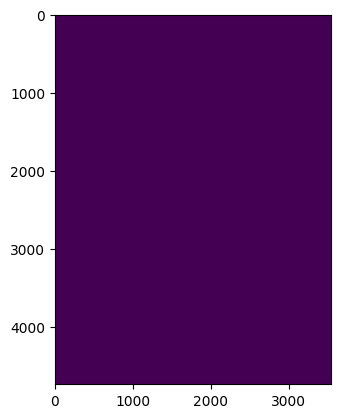

In [110]:
plt.imshow(img)

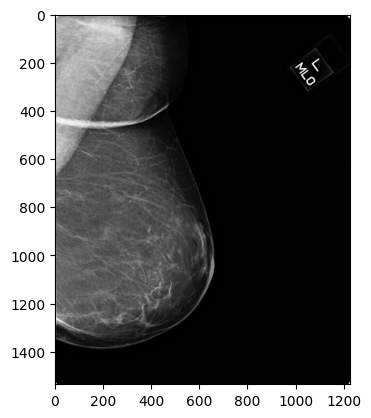

In [31]:
plt.imshow(load_img)

In [ ]:
load_img

In [95]:
load_img.shape

(1536, 1225, 3)

In [100]:
resize_img = cv2.resize(load_img , (1536,1536))

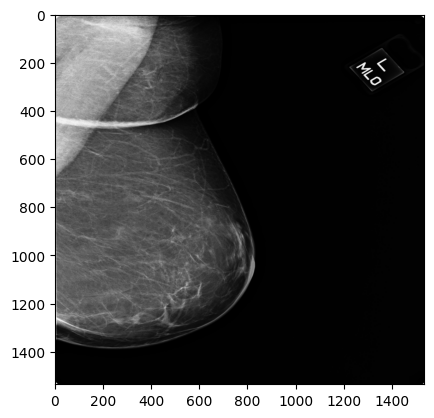

In [101]:
plt.imshow(resize_img)

In [6]:
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)


def truncation_normalization(img):
    """
    Clip and normalize pixels in the breast ROI.
    @img : numpy array image
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized


def clahe(img, clip):
    """
    Image enhancement.
    @img : numpy array image
    @clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [7]:
import matplotlib.patches as patches

In [50]:

def get_crop_cords(img_path):
    image_dir = 'input_data/mask_224'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(224,224))
    # (x, y, w, h) = crop_coords(img)
    _, _, machine_id ,patient_id ,image_id  = img_path.split('/')
    os.makedirs(f'{image_dir}/{machine_id}/{patient_id}', exist_ok=True)
    cv2.imwrite(f'{image_dir}/{machine_id}/{patient_id}/{image_id}', img)
    # return [x, y, w, h]

In [51]:
with mp.Pool(72) as p:
    out = list(tqdm(p.imap(get_crop_cords, cc), total=len(cc)))

100%|██████████| 54706/54706 [00:46<00:00, 1185.81it/s]


In [45]:
_, _, machine_id ,patient_id ,image_id  = cc[1].split('/')

In [46]:
cc[1].split('/') , machine_id ,patient_id ,image_id

(['input_data', 'train_VOI_LUT_1536', '210', '44122', '45101866.png'],
 '210',
 '44122',
 '45101866.png')

In [36]:
images = []
bbox = []
image_dir = 'input_data/mask_224'
for img_path in tqdm(cc):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(224,224))
    (x, y, w, h) = crop_coords(img)
    # Create a Rectangle patch
    # rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    # ax.add_patch(rect)
    bbox.append([x, y, w, h])
    # save as png
    machine_id ,patient_id ,image_id = img_path.split('/')
    
    os.makedirs(f'{image_dir}/{machine_id}/{patient_id}', exist_ok=True)
    cv2.imwrite(f'{image_dir}/{machine_id}/{patient_id}/{image_id}', img)
    # img_cropped = img[y:y+h, x:x+w]
    # images.append(img_cropped)
    # ax.imshow(img, cmap="bone")

# plt.savefig("rectangles.png")
# plt.show()


# for plotting and display

# _, axs = plt.subplots(2, 5, figsize=(16, 8))
# axs = axs.flatten()

# for img_path, ax in zip(cc[:10],axs):
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img,(224,224))
#     (x, y, w, h) = crop_coords(img)
    # Create a Rectangle patch
    # rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    # ax.add_patch(rect)
    # bbox.append([x, y, w, h])
    # img_cropped = img[y:y+h, x:x+w]
    # images.append(img_cropped)
    # ax.imshow(img, cmap="bone")

# plt.savefig("rectangles.png")
# plt.show()


In [37]:
df = pd.DataFrame(cc,columns=['img_path'])

In [38]:
df['bbox']= out

In [41]:
df.to_csv('output/image_path with_bbox.csv',index=False)

In [47]:
import torch
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

In [48]:
num_train_steps = int(10 /8)

In [83]:
total_iterations = int((54000 / 6) * 8)

In [84]:
total_iterations

72000

In [87]:
int(54600 / 6 * 8 )

72800

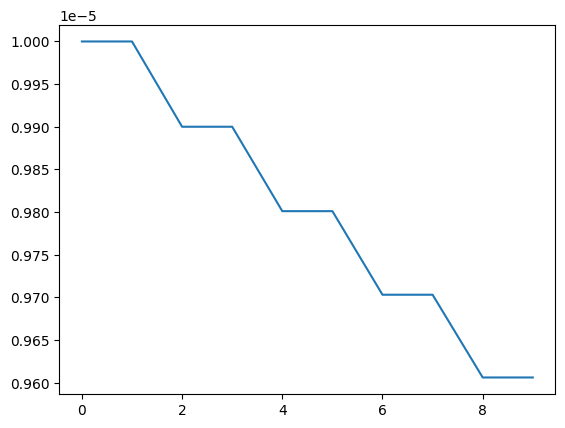

In [104]:
model = torch.nn.Linear(2, 1)
# optimizer = torch.optim.SGD(model.parameters(), lr=100)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.98)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=4,num_training_steps=num_train_steps)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, steps_per_epoch=54200, epochs=10)


# scheduler =torch.optim.lr_scheduler.OneCycleLR(
#         optimizer,
#         max_lr=1e-5,
#         epochs=8,
#         steps_per_epoch=int(54600 / 6 * 8 ),
#         pct_start=0.1,
#         anneal_strategy="cos",
#         div_factor=1.0,
#         final_div_factor=1000,
#     )

# max_lr = 0.001
# min_lr = 0.0001
# total_iterations = (54000 / 6) * 8

# # Define the learning rate scheduler
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs = 8 , steps_per_epoch = total_iterations, 
#                        div_factor=10, final_div_factor=1)

lrs = []

for i in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ",0.1 if i!=0 and i%2!=0 else 1," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plt.plot(range(10),lrs)

In [105]:
lrs

[1e-05,
 1e-05,
 9.9e-06,
 9.9e-06,
 9.801e-06,
 9.801e-06,
 9.70299e-06,
 9.70299e-06,
 9.6059601e-06,
 9.6059601e-06]

## Pipeline to crop the region of intrest and train a model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *

from timm.models.resnet import *

import cv2
import numpy as np

In [102]:
class PreprocessDataset(Dataset):
    def __init__(self, df, image_size=224):
        self.df = df
        self.length = len(df)
        self.image_size = image_size

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        m = cv2.imread(d.png_file, cv2.IMREAD_GRAYSCALE)
        h, w = m.shape
        image = np.zeros((self.image_size, self.image_size), np.uint8)
        
        

        s = self.image_size /h
        h, w = int(s * h), int(s * w)
        m = cv2.resize(m, dsize=(w, h), interpolation=cv2.INTER_LINEAR)
        y = (self.image_size - h) // 2
        x = (self.image_size - w) // 2
        rect = (x, y, x + w, y + h)

        image[y:y + h, x:x + w] = m
        image = image.astype(np.float32) / 255

        r = {}
        r['index'] = index
        r['d'    ] = d
        r['rect' ] = rect
        r['image'] = torch.from_numpy(image).float()
        return r

def proprocess_collate(batch):
    d = {}
    key = batch[0].keys()
    for k in key:
        v = [b[k] for b in batch]
        d[k] = v
    d['image'] = torch.stack(d['image'],0).unsqueeze(1)
    return d


In [78]:
df_roi_test = pd.read_csv('input_data/kfold_train.csv')

In [82]:
cc[:4]

['input_data/train_VOI_LUT_1536/210/44122/2119016582.png',
 'input_data/train_VOI_LUT_1536/210/44122/45101866.png',
 'input_data/train_VOI_LUT_1536/210/44122/1214460287.png',
 'input_data/train_VOI_LUT_1536/210/44122/1699991315.png']

In [83]:
df_roi_test['png_file'] = df_roi_test.apply(lambda row : ''.join('input_data/train_VOI_LUT_1536/'+str(row['machine_id'])+'/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.png'), axis=1)

In [103]:
dataset = PreprocessDataset(df_roi_test.head(30))
loader = DataLoader(
    dataset,
    sampler = SequentialSampler(dataset),
    batch_size  = 32,
    drop_last   = False,
    num_workers = 2,
    pin_memory  = False,
    collate_fn = proprocess_collate,
)


In [106]:
check_loader =next(iter(loader))

In [129]:
check_loader['d'][2]

site_id                                                                    2
patient_id                                                             10006
image_id                                                          1864590858
laterality                                                                 1
view                                                                       0
age                                                                     61.0
cancer                                                                     0
biopsy                                                                     0
invasive                                                                   0
BIRADS                                                                   NaN
implant                                                                    0
density                                                                  NaN
machine_id                                                                29

In [131]:
check_mask = check_loader['image'][2].permute(1,2,0).cpu().detach().numpy()

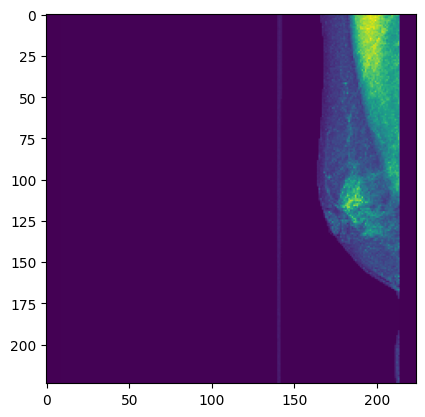

In [128]:
plt.imshow(check_loader['image'][2].permute(1,2,0).cpu().detach().numpy())

In [ ]:
thresh = ((predict>0.5)*255).astype(np.uint8)
contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # CHAIN_APPROX_NONE     CHAIN_APPROX_SIMPLE
c = max(contour, key=cv2.contourArea)
m0 = np.zeros(shape=thresh.shape, dtype=np.uint8)
cv2.drawContours(m0, [c], -1, 255, thickness=-1)

#step.2 erode
element = cv2.getStructuringElement( cv2.MORPH_ELLIPSE, (2 * erosion_size + 1, 2 * erosion_size + 1), (erosion_size, erosion_size))
m1 = cv2.erode(m0, element)
contour, hierarchy = cv2.findContours(m1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # CHAIN_APPROX_NONE     CHAIN_APPROX_SIMPLE
c = max(contour, key=cv2.contourArea)
m1[...]=0
cv2.drawContours(m1, [c], -1, 255, thickness=-1)

#step.3 dilate
m2 = cv2.dilate(m1, element)

ss = (m0 == m2).sum()
if ss < min_diff:
    mask = m0
else:
    mask = m2



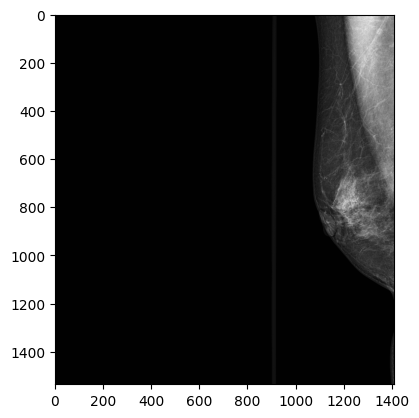

In [130]:
plt.imshow(cv2.imread('input_data/train_VOI_LUT_1536/29/10006/1864590858.png'))

# Diff crop mechanism

In [7]:

TARGET_HEIGHT = 1536
TARGET_WIDTH = 768
N_CHANNELS = 1
INPUT_SHAPE = (TARGET_HEIGHT, TARGET_WIDTH, N_CHANNELS)
TARGET_HEIGHT_WIDTH_RATIO = TARGET_HEIGHT / TARGET_WIDTH
THRESHOLD_BEST = 0.50

CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))

CROP_IMAGE = True
APPLY_CLAHE = False
APPLY_EQ_HIST = False


CROP_IMAGE = True
APPLY_CLAHE = False
APPLY_EQ_HIST = False
png_dir = '/input/tmp/~png' 
IMAGE_FORMAT = 'png'

In [8]:
def voi_lut(image, dicom, process_j2k=False):
    # Additional Checks
    if process_j2k:
        if 'WindowWidth' not in dicom:
            return image
    else:
        if 'WindowWidth' not in dicom.getPixelDataInfo():
            return image
        
    
#     if 'WindowWidth' not in dicom.getPixelDataInfo() or 'WindowWidth' not in dicom.getPixelDataInfo():
#         return image
    
    # Load only the variables we need
    center = float(dicom.getPixelDataInfo()['WindowCenter'])
    width = float(dicom.getPixelDataInfo()['WindowWidth'])
    bits_stored = float(dicom.getPixelDataInfo()['BitsStored'])
    try : 
        voi_lut_function = dicom.getPixelDataInfo()['VOILUTFunction']
    except:
        voi_lut_function = None
    
#     center = dicom['WindowCenter']
#     width = dicom['WindowWidth']
#     bits_stored = dicom['BitsStored']
#     voi_lut_function = dicom['VOILUTFunction']

    # For sigmoid it's a list, otherwise a single value
    if isinstance(center, list):
        center = center[0]
    if isinstance(width, list):
        width = width[0]

    # Set y_min, max & range
    y_min = 0
    y_max = float(2**bits_stored - 1)
    y_range = y_max

    # Function with default LINEAR (so for Nan, it will use linear)
    if voi_lut_function == 'SIGMOID':
        image = y_range / (1 + np.exp(-4 * (image - center) / width)) + y_min
    else:
        # Checks width for < 1 (in our case not necessary, always >= 750)
        center -= 0.5
        width -= 1

        below = image <= (center - width / 2)
        above = image > (center + width / 2)
        between = np.logical_and(~below, ~above)

        image[below] = y_min
        image[above] = y_max
        if between.any():
            image[between] = (
                ((image[between] - center) / width + 0.5) * y_range + y_min
            )

    return image

In [9]:
# Smooth vector used to smoothen sums/stds of axes
def smooth(l):
    # kernel size is 1% of vector
    kernel_size = int(len(l) * 0.01)
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(l, kernel, mode='same')

# X Crop offset based on first column with sum below 5% of maximum column sums*std
def get_x_offset(image, max_col_sum_ratio_threshold=0.05, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Percentual margin added to offset
    margin = int(image.shape[1] * 0.00)
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=0).squeeze()) * smooth(image.std(axis=0).squeeze())
    # Find maximum sum in first 75% of columns
    vv_argmax = vv[:int(image.shape[1] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_col_sum_ratio_threshold
    
    # Find first column after maximum column below threshold value
    for offset, v in enumerate(vv):
        # Start searching from vv_argmax
        if offset < vv_argmax:
            continue
        
        # Column below threshold value found
        if v < vv_threshold:
            offset = min(W, offset + margin)
            break
            
    if isinstance(debug, np.ndarray):
        debug[1].imshow(image)
        debug[1].set_title('X Offset')
        vv_scale = H / vv.max() * 0.90
        # Values
        debug[1].plot(H - vv * vv_scale , c='red', label='vv')
        # Threshold
        debug[1].hlines(H - vv_threshold * vv_scale, 0, W -1, colors='orange', label='threshold')
        # Max Value
        debug[1].scatter(vv_argmax, H - vv[vv_argmax] * vv_scale, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[1].scatter(offset, H - vv[offset] * vv_scale, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[1].set_ylim(H, 0)
        debug[1].legend()
        debug[1].axis('off')
        
    return offset

# Y Crop offset based on first bottom and top rows with sum below 10% of maximum row sum*std
def get_y_offsets(image, max_row_sum_ratio_threshold=0.10, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Margin to add to offsets
    margin = 0
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=1).squeeze()) * smooth(image.std(axis=1).squeeze())
    # Find maximum sum * std row in inter quartile rows
    vv_argmax = int(image.shape[0] * 0.25) + vv[int(image.shape[0] * 0.25):int(image.shape[0] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_row_sum_ratio_threshold
    # Default crop offsets
    offset_bottom = 0
    offset_top = H

    # Bottom offset, search from argmax to bottom
    for offset in reversed(range(0, vv_argmax)):
        v = vv[offset]
        if v < vv_threshold:
            offset_bottom = offset
            break
    
    if isinstance(debug, np.ndarray):
        debug[2].imshow(image)
        debug[2].set_title('Y Bottom Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[2].plot(vv * vv_scale, np.arange(H), c='red', label='vv')
        # Threshold
        debug[2].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[2].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[2].scatter(vv[offset_bottom] * vv_scale, offset_bottom, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[2].legend()
        debug[2].axis('off')
            
    # Top offset, search from argmax to top
    for offset in range(vv_argmax, H):
        v = vv[offset]
        if v < vv_threshold:
            offset_top = offset
            break
            
    if isinstance(debug, np.ndarray):
        debug[3].imshow(image)
        debug[3].set_title('Y Top Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[3].plot(vv * vv_scale, np.arange(H) , c='red', label='vv')
        # Threshold
        debug[3].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[3].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[3].scatter(vv[offset_top] * vv_scale, offset_top, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[3].legend()
        debug[3].axis('off')
            
    return max(0, offset_bottom - margin), min(image.shape[0], offset_top + margin)

# Crop image and pad offsets to target image height/width ratio to preserve information
def crop(image, size=None, debug=False):
    # Image dimensions
    H, W = image.shape
    # Compute x/bottom/top offsets
    x_offset = get_x_offset(image, debug=debug)
    offset_bottom, offset_top = get_y_offsets(image[:,:x_offset], debug=debug)
    # Crop Height and Width
    h_crop = offset_top - offset_bottom
    w_crop = x_offset
    
    # Pad crop offsets to target aspect ratio
    if size is not None:
        # Height too large, pad x offset
        if (h_crop / w_crop) > TARGET_HEIGHT_WIDTH_RATIO:
            x_offset += int(h_crop / TARGET_HEIGHT_WIDTH_RATIO - w_crop)
        else:
            # Height too small, pad bottom/top offsets
            offset_bottom -= int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_bottom_correction = max(0, -offset_bottom)
            offset_bottom += offset_bottom_correction

            offset_top += int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_top += offset_bottom_correction
        
    # Crop Image
    image = image[offset_bottom:offset_top:,:x_offset]
        
    return image

def resize_image_to_height(image, image_height):
    h, w = image.shape[:2]
    s = image_height/h
    if image_height!=h:
        image = cv2.resize(image, dsize=None, fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
    return image

In [10]:
def process(file_path, size=(TARGET_WIDTH, TARGET_HEIGHT), crop_image=CROP_IMAGE, apply_clahe=APPLY_CLAHE, apply_eq_hist=APPLY_EQ_HIST, debug=False, save=True):
    # Read Dicom File
    dicom = dicomsdl.open(file_path)
    image = dicom.pixelData()
    
    # Save original image for debug purposes
    if debug:
        fig, axes = plt.subplots(1, 5, figsize=(20,10))
        image0 = np.copy(image)
        axes[0].imshow(image0)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
    else:
        axes = False
    
    
    # resize
    image = resize_image_to_height(image, TARGET_HEIGHT)
    
    # voi_lut
    try:
        image = voi_lut(image, dicom)
    except:
        pass
    
    # Some images have 0 values as highest intensity and need to be inverted
    if dicom.getPixelDataInfo()['PhotometricInterpretation'] == 'MONOCHROME1':
        image = np.max(image) - image

    # Normalize [0,1] range
    image = (image - image.min()) / (image.max() - image.min())

    # Convert to uint8 image in range [0, 255]
    image = (image * 255).astype(np.uint8)
    
    # Flip T0 Left/Right Orientation
    h0, w0 = image.shape
    if image[:,int(-w0 * 0.10):].sum() > image[:,:int(w0 * 0.10)].sum():
        image = np.flip(image, axis=1)
    
    # Crop Image
    if crop_image:
        try:
            image = crop(image, debug=axes)
        except:
            image = cv2.resize(image,size)
        
    # Resize
    if size is not None:
        # Pad black pixels to make square image
        h, w,_ = image.shape
        if (h / w) > TARGET_HEIGHT_WIDTH_RATIO:
            pad = int(h / TARGET_HEIGHT_WIDTH_RATIO - w)
            image = np.pad(image, [[0,0], [0, pad]])
            h, w = image.shape
        else:
            pad = int(0.50 * (w * TARGET_HEIGHT_WIDTH_RATIO - h))
            image = np.pad(image, [[pad, pad], [0,0]])
            h, w = image.shape
        # Resize
        image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
        
    # Apply CLAHE contrast enhancement
    if apply_clahe:
        image = CLAHE.apply(image)
        
     # Apply Histogram Equalization
    if apply_eq_hist:
        image = cv2.equalizeHist(image)
        
    # Show Processed Image    
    if debug:
        axes[4].imshow(image)
        axes[4].set_title('Processed Image')
        axes[4].axis('off')
        plt.show()
        
    # Save Only
    if save:
        image_id = file_path.split('/')[-1].split('.')[0]
        patient_id = file_path.split("/")[-2]

        if IMAGE_FORMAT == 'png':
            os.makedirs(f'{image_dir}/{patient_id}', exist_ok=True)
            cv2.imwrite(f'{image_dir}/{patient_id}/{image_id}.png', image)
        else:
            cv2.imwrite(f'{image_id}.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, 95])

In [11]:
def process_smart(file_path, size=(TARGET_WIDTH, TARGET_HEIGHT), crop_image=CROP_IMAGE, apply_clahe=APPLY_CLAHE, apply_eq_hist=APPLY_EQ_HIST, debug=False, save=True):
    # Read Dicom File
    dicom = dicomsdl.open(file_path)
    image = dicom.pixelData()
    
    # Save original image for debug purposes
    if debug:
        fig, axes = plt.subplots(1, 5, figsize=(20,10))
        image0 = np.copy(image)
        axes[0].imshow(image0)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
    else:
        axes = False
    
    
    # resize
    image1 = resize_image_to_height(image.copy(), 2048)
    image2 = resize_image_to_height(image.copy(), 1024)
    image3 = resize_image_to_height(image.copy(), 1536)
    
    # voi_lut
    try:
        image1 = voi_lut(image1, dicom)
        image2 = voi_lut(image2, dicom)
        image3 = voi_lut(image3, dicom)
        
        
    except:
        pass
    
    # Some images have 0 values as highest intensity and need to be inverted
    if dicom.getPixelDataInfo()['PhotometricInterpretation'] == 'MONOCHROME1':
        image1 = np.max(image1) - image1
        image2 = np.max(image2) - image2
        image3 = np.max(image3) - image3
        
        

    # Normalize [0,1] range
    image1 = (image1 - image1.min()) / (image1.max() - image1.min())
    image2 = (image2 - image2.min()) / (image2.max() - image2.min())
    image3 = (image3 - image3.min()) / (image3.max() - image3.min())

    # Convert to uint8 image in range [0, 255]
    image1 = (image1 * 255).astype(np.uint8)
    image2 = (image2 * 255).astype(np.uint8)
    image3 = (image3 * 255).astype(np.uint8)
    
    # Flip T0 Left/Right Orientation
    h0, w0 = image1.shape
    if image1[:,int(-w0 * 0.10):].sum() > image1[:,:int(w0 * 0.10)].sum():
        image1 = np.flip(image1, axis=1)
        
    h0, w0 = image2.shape
    if image2[:,int(-w0 * 0.10):].sum() > image2[:,:int(w0 * 0.10)].sum():
        image2 = np.flip(image2, axis=1)
        
    h0, w0 = image3.shape
    if image3[:,int(-w0 * 0.10):].sum() > image3[:,:int(w0 * 0.10)].sum():
        image3 = np.flip(image3, axis=1)
    
    # Crop Image
    if crop_image:
        try:
            image1 = crop(image1, debug=axes)
            image2 = crop(image2, debug=axes)
            image3 = crop(image3, debug=axes)
        except:
            image1 = cv2.resize(image1,(1024,2048))
            image2 = cv2.resize(image2,(512,1024))
            image3 = cv2.resize(image3,(768,1536))
        
            
    # Resize
    if size is not None:
        # Pad black pixels to make square image
        h, w = image1.shape
        TARGET_HEIGHT_WIDTH_RATIO = 2048 / 1024
        if (h / w) > TARGET_HEIGHT_WIDTH_RATIO:
            pad = int(h / TARGET_HEIGHT_WIDTH_RATIO - w)
            image1 = np.pad(image1, [[0,0], [0, pad]])
            h, w = image1.shape
        else:
            pad = int(0.50 * (w * TARGET_HEIGHT_WIDTH_RATIO - h))
            image1 = np.pad(image1, [[pad, pad], [0,0]])
            h, w = image1.shape
        # Resize
        image1 = cv2.resize(image1, (1024,2048), interpolation=cv2.INTER_AREA)
 
        h, w = image2.shape
        TARGET_HEIGHT_WIDTH_RATIO = 1024 / 512
        if (h / w) > TARGET_HEIGHT_WIDTH_RATIO:
            pad = int(h / TARGET_HEIGHT_WIDTH_RATIO - w)
            image2 = np.pad(image2, [[0,0], [0, pad]])
            h, w = image2.shape
        else:
            pad = int(0.50 * (w * TARGET_HEIGHT_WIDTH_RATIO - h))
            image2 = np.pad(image2, [[pad, pad], [0,0]])
            h, w = image2.shape
        # Resize
        image2 = cv2.resize(image2, (512,1024), interpolation=cv2.INTER_AREA)
    
        h, w = image3.shape
        TARGET_HEIGHT_WIDTH_RATIO = 1536 / 768
        if (h / w) > TARGET_HEIGHT_WIDTH_RATIO:
            pad = int(h / TARGET_HEIGHT_WIDTH_RATIO - w)
            image3 = np.pad(image3, [[0,0], [0, pad]])
            h, w = image3.shape
        else:
            pad = int(0.50 * (w * TARGET_HEIGHT_WIDTH_RATIO - h))
            image3 = np.pad(image3, [[pad, pad], [0,0]])
            h, w = image3.shape
        # Resize
        image3 = cv2.resize(image3, (768,1536), interpolation=cv2.INTER_AREA)

    # Apply CLAHE contrast enhancement
    if apply_clahe:
        image1 = CLAHE.apply(image1)
        image2 = CLAHE.apply(image2)
        image3 = CLAHE.apply(image3)
        
     # Apply Histogram Equalization
    if apply_eq_hist:
        image1 = cv2.equalizeHist(image1)
        image2 = cv2.equalizeHist(image2)
        image3 = cv2.equalizeHist(image3)
        
    # Show Processed Image    
    if debug:
        axes[4].imshow(image)
        axes[4].set_title('Processed Image')
        axes[4].axis('off')
        plt.show()
        
    # Save Only
    if save:
        image_id = file_path.split('/')[-1].split('.')[0]
        patient_id = file_path.split("/")[-2]

        if IMAGE_FORMAT == 'png':
            os.makedirs(f'{image_dir1}/{patient_id}', exist_ok=True)
            cv2.imwrite(f'{image_dir1}/{patient_id}/{image_id}.png', image1)
            
            os.makedirs(f'{image_dir2}/{patient_id}', exist_ok=True)
            cv2.imwrite(f'{image_dir2}/{patient_id}/{image_id}.png', image2)
            
            os.makedirs(f'{image_dir3}/{patient_id}', exist_ok=True)
            cv2.imwrite(f'{image_dir3}/{patient_id}/{image_id}.png', image3)
        else:
            cv2.imwrite(f'{image_id}.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, 95])        

In [42]:
image_dir1 = "input_data/train_crop_voilut_2048"
image_dir2 = "input_data/train_crop_voilut_1024"
image_dir3 = "input_data/train_crop_voilut_1536"
os.makedirs(f"{image_dir1}", exist_ok=True)
os.makedirs(f"{image_dir2}", exist_ok=True)
os.makedirs(f"{image_dir3}", exist_ok=True)

In [43]:
import cv2

In [52]:
laad_df = pd.read_csv('input_data/kfold_train.csv')

In [12]:
external_df = pd.read_csv('external_data/additional_train.csv')

In [13]:
external_df.head()

patient_id laterality view  cancer
0    P_00127      RIGHT   CC       1
1    P_00127      RIGHT  MLO       1
2    P_00150      RIGHT  MLO       1
3    P_00164      RIGHT   CC       1
4    P_00202      RIGHT   CC       1

In [53]:
laad_df.kfold.value_counts()

1    10950
4    10942
2    10941
3    10939
0    10934
Name: kfold, dtype: int64

In [45]:
laad_df.head()

site_id  patient_id    image_id  laterality  view   age  cancer  biopsy  \
0        2       10006   462822612           0     1  61.0       0       0   
1        2       10006  1459541791           0     0  61.0       0       0   
2        2       10006  1864590858           1     0  61.0       0       0   
3        2       10006  1874946579           1     1  61.0       0       0   
4        2       10011   220375232           0     1  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   
3         0     NaN        0     NaN          29                    False   
4         0     0.0        0     NaN          21                     True   

  orientation                                  orignal_path  \
0        L-CC   input_data/train_images/10006/462822612.dcm   
1       L-MLO  input_data/train_images/10006/1459541791.dcm   
2       R-MLO  input_data/train_images/10006/1864590858.dcm   
3        R-CC  input_data/train_images/10006/1874946579.dcm   
4        L-CC   input_data/train_images/10011/220375232.dcm   

                                          dump_path  kfold   mean_age  
0   input_data/train_images_png/10006/462822612.png      3  59.153744  
1  input_data/train_images_png/10006/1459541791.png      3  59.153744  
2  input_data/train_images_png/10006/1864590858.png      3  59.153744  
3  input_data/train_images_png/10006/1874946579.png      3  59.153744  
4   input_data/train_images_png/10011/220375232.png      1  60.198516

In [189]:
# check_df = laad_df[laad_df.image_id.isin([983751012,195902570,1217518709])]

In [190]:
# check_df = laad_df[laad_df.image_id.isin([1942326353,1743461841])]

In [191]:
# N = 8

# for fp in tqdm(check_df['orignal_path']):
#     process(fp, crop_image=True, size=(TARGET_WIDTH, TARGET_HEIGHT), debug=True, save=False)

In [192]:
# N = 8

# for fp in tqdm(check_df['orignal_path']):
#     process(fp, crop_image=True, size=(TARGET_WIDTH, TARGET_HEIGHT), debug=True, save=False)

In [193]:
# N = 8

# for fp in tqdm(laad_df['orignal_path'].head(N)):
#     process(fp, crop_image=True, size=(TARGET_WIDTH, TARGET_HEIGHT), debug=True, save=False)

In [48]:
def preprocess_and_save_image(args):
    (patient_id,laterality), g = args
    cancer = 0.0
    for row_idx, row in g.iterrows():
        process_smart(row['orignal_path'])

In [49]:
from joblib import Parallel, delayed
import joblib

In [50]:
start_time = time.time()
jobs = [joblib.delayed(preprocess_and_save_image)(args) for args in laad_df.groupby(['patient_id', 'laterality'])]
SUBMISSION_ROWS = joblib.Parallel(
    n_jobs=82,#cpu_count(),
    backend='multiprocessing',
    prefer='threads',
)(jobs)

print(f"Total Time taken {int(time.time()-start_time)/60} mins")

Total Time taken 255.76666666666668 mins


In [29]:
import glob

In [34]:
glob.glob('input_data/train_cropped_1536/*/**.png')[-10]

'input_data/train_cropped_1536/18891/1172943074.png'

In [35]:
ll = cv2.imread('input_data/train_cropped_1536/18891/1172943074.png')

In [36]:
ll.shape

(1536, 768, 3)

In [23]:
import time

Total Time taken 0.9833333333333333 mins


## Augment Positive Samples

In [6]:
cancer_df = laad_df[laad_df.cancer==1]
non_cancer_df = laad_df[laad_df.cancer==0]

In [7]:
cancer_df['dump_path'] = cancer_df.apply(lambda row : ''.join('input_data/train_cropped_1536'+'/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.png'), axis=1)

/tmp/ipykernel_102/2097544597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df['dump_path'] = cancer_df.apply(lambda row : ''.join('input_data/train_cropped_1536'+'/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.png'), axis=1)


In [8]:
cancer_df = cancer_df[cancer_df.image_id!=1743461841]

In [9]:
cancer_df

site_id  patient_id    image_id  laterality  view   age  cancer  \
87           1       10130   388811999           0     0  71.0       1   
88           1       10130   613462606           0     1  71.0       1   
89           1       10130  1360338805           0     1  71.0       1   
90           1       10130  1672636630           0     0  71.0       1   
190          1       10226   461614796           0     0  71.0       1   
...        ...         ...         ...         ...   ...   ...     ...   
54485        2        9707  1900919592           1     0  56.0       1   
54593        2        9840   111786935           1     0  59.0       1   
54594        2        9840  1559360810           1     1  59.0       1   
54595        2        9851  1409270544           0     0  58.0       1   
54596        2        9851  1434430689           0     1  58.0       1   

       biopsy  invasive  BIRADS  implant density  machine_id  \
87          1         1     0.0        0       B          49   
88          1         1     0.0        0       B          49   
89          1         1     0.0        0       B          49   
90          1         1     0.0        0       B          49   
190         1         1     0.0        0       C          49   
...       ...       ...     ...      ...     ...         ...   
54485       1         1     NaN        0     NaN          21   
54593       1         1     NaN        0     NaN          21   
54594       1         1     NaN        0     NaN          21   
54595       1         0     NaN        0     NaN          48   
54596       1         0     NaN        0     NaN          48   

       difficult_negative_case orientation  \
87                       False       L-MLO   
88                       False        L-CC   
89                       False        L-CC   
90                       False       L-MLO   
190                      False       L-MLO   
...                        ...         ...   
54485                    False       R-MLO   
54593                    False       R-MLO   
54594                    False        R-CC   
54595                    False       L-MLO   
54596                    False        L-CC   

                                       orignal_path  \
87      input_data/train_images/10130/388811999.dcm   
88      input_data/train_images/10130/613462606.dcm   
89     input_data/train_images/10130/1360338805.dcm   
90     input_data/train_images/10130/1672636630.dcm   
190     input_data/train_images/10226/461614796.dcm   
...                                             ...   
54485   input_data/train_images/9707/1900919592.dcm   
54593    input_data/train_images/9840/111786935.dcm   
54594   input_data/train_images/9840/1559360810.dcm   
54595   input_data/train_images/9851/1409270544.dcm   
54596   input_data/train_images/9851/1434430689.dcm   

                                               dump_path  kfold   mean_age  
87     input_data/train_cropped_1536/10130/388811999.png      0  57.268687  
88     input_data/train_cropped_1536/10130/613462606.png      0  57.268687  
89     input_data/train_cropped_1536/10130/1360338805...      0  57.268687  
90     input_data/train_cropped_1536/10130/1672636630...      0  57.268687  
190    input_data/train_cropped_1536/10226/461614796.png      4  57.268687  
...                                                  ...    ...        ...  
54485  input_data/train_cropped_1536/9707/1900919592.png      0  60.198516  
54593   input_data/train_cropped_1536/9840/111786935.png      3  60.198516  
54594  input_data/train_cropped_1536/9840/1559360810.png      3  60.198516  
54595  input_data/train_cropped_1536/9851/1409270544.png      1  60.435452  
54596  input_data/train_cropped_1536/9851/1434430689.png      1  60.435452  

[1157 rows x 19 columns]

In [10]:
non_cancer_df.shape

(53548, 19)

## Reshuffle the data and create folds

In [2]:
load_kfold_data = pd.read_csv('input_data/kfold_train.csv')
load_augmentated_data =pd.read_csv('input_data/cancer_augment_flipped_data.csv')

In [8]:
load_kfold_data.head()

site_id  patient_id    image_id  laterality  view   age  cancer  biopsy  \
0        2       10006   462822612           0     1  61.0       0       0   
1        2       10006  1459541791           0     0  61.0       0       0   
2        2       10006  1864590858           1     0  61.0       0       0   
3        2       10006  1874946579           1     1  61.0       0       0   
4        2       10011   220375232           0     1  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   
3         0     NaN        0     NaN          29                    False   
4         0     0.0        0     NaN          21                     True   

  orientation                                  orignal_path  \
0        L-CC   input_data/train_images/10006/462822612.dcm   
1       L-MLO  input_data/train_images/10006/1459541791.dcm   
2       R-MLO  input_data/train_images/10006/1864590858.dcm   
3        R-CC  input_data/train_images/10006/1874946579.dcm   
4        L-CC   input_data/train_images/10011/220375232.dcm   

                                          dump_path  kfold   mean_age  
0   input_data/train_images_png/10006/462822612.png      3  59.153744  
1  input_data/train_images_png/10006/1459541791.png      3  59.153744  
2  input_data/train_images_png/10006/1864590858.png      3  59.153744  
3  input_data/train_images_png/10006/1874946579.png      3  59.153744  
4   input_data/train_images_png/10011/220375232.png      1  60.198516

In [9]:
load_augmentated_data.kfold.value_counts()

4    232
3    232
0    231
1    231
2    231
Name: kfold, dtype: int64

In [23]:
master_kfold_data = pd.concat([load_augmentated_data,load_kfold_data]).reset_index(drop=True)

In [24]:
load_kfold_data.kfold.value_counts()

1    10950
4    10942
2    10941
3    10939
0    10934
Name: kfold, dtype: int64

In [25]:
master_kfold_data.kfold.value_counts()

1    11181
4    11174
2    11172
3    11171
0    11165
Name: kfold, dtype: int64

In [39]:
master_kfold_data = master_kfold_data[master_kfold_data.image_id!=1743461841]

In [40]:
master_kfold_data = master_kfold_data.sample(frac=1).reset_index(drop=True)

In [5]:
# master_kfold_data.to_csv('input_data/master_kfold_data.csv',index=False)
master_kfold_data= pd.read_csv('input_data/master_kfold_data.csv')

In [11]:
master_kfold_data[master_kfold_data.kfold!=2].shape , master_kfold_data[master_kfold_data.kfold==2].shape

((44691, 20), (11171, 20))

In [13]:
42839//(8*12)

446

In [12]:
master_kfold_data[master_kfold_data.kfold!=2]['cancer'].value_counts()

0    42839
1     1852
Name: cancer, dtype: int64

### Export the data and add back for each of them

In [3]:
load_augmentated_data.shape

(1157, 19)

In [4]:
# load_augmentated_data['dump_path'] = load_augmentated_data.apply(lambda row : ''.join(image_dir+'/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.png'), axis=1)


In [5]:
load_augmentated_data.head(5)

site_id  patient_id    image_id  laterality  view   age  cancer  biopsy  \
0        1       10130   713046241           1     0  71.0       1       1   
1        1       10130   937696848           1     1  71.0       1       1   
2        1       10130  1684573047           1     1  71.0       1       1   
3        1       10130  1996870872           1     0  71.0       1       1   
4        1       10226   785849038           1     0  71.0       1       1   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         1     0.0        0       B          49                    False   
1         1     0.0        0       B          49                    False   
2         1     0.0        0       B          49                    False   
3         1     0.0        0       B          49                    False   
4         1     0.0        0       C          49                    False   

  orientation                                  orignal_path  \
0       R-MLO   input_data/train_images/10130/388811999.dcm   
1        R-CC   input_data/train_images/10130/613462606.dcm   
2        R-CC  input_data/train_images/10130/1360338805.dcm   
3       R-MLO  input_data/train_images/10130/1672636630.dcm   
4       R-MLO   input_data/train_images/10226/461614796.dcm   

                                           dump_path  kfold   mean_age  
0  input_data/train_cropped_1536/10130/388811999.png      0  57.268687  
1  input_data/train_cropped_1536/10130/613462606.png      0  57.268687  
2  input_data/train_cropped_1536/10130/1360338805...      0  57.268687  
3  input_data/train_cropped_1536/10130/1672636630...      0  57.268687  
4  input_data/train_cropped_1536/10226/461614796.png      4  57.268687

In [76]:
img_load = cv2.imread('input_data/train_crop_voilut_1536/10130/937696848.png')
flipped_img = cv2.flip(img_load, 1)

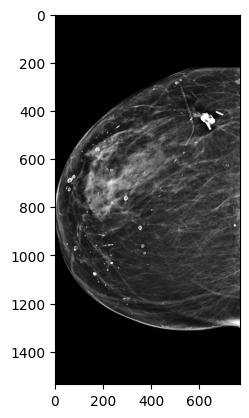

In [77]:
plt.imshow(img_load)

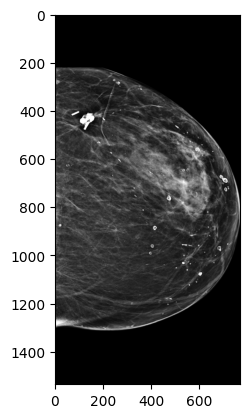

In [79]:
plt.imshow(flipped_img)

In [6]:
image_dir = "input_data/train_crop_voilut_1024"
# os.makedirs(f"{image_dir}", exist_ok=True)

In [7]:
for idx , _df in load_augmentated_data.iterrows():
    img_load = cv2.imread(_df['dump_path'])
    flipped_img = cv2.flip(img_load, 1)
    # print(f"{image_dir}/{_df['patient_id']}/{_df['image_id']}.png")
    cv2.imwrite(f"{image_dir}/{_df['patient_id']}/{_df['image_id']}.png",flipped_img)
    

## Check Weighted Sampler

In [26]:
master_kfold_data[master_kfold_data.kfold!=1].shape

(44682, 19)

In [107]:
master_kfold_data= pd.read_csv('input_data/master_kfold_data.csv')

In [108]:
master_kfold_data = master_kfold_data[master_kfold_data.kfold!=4].reset_index(drop=True)

In [109]:
from exhaustive_weighted_random_sampler import ExhaustiveWeightedRandomSampler

In [110]:
master_kfold_data = master_kfold_data[master_kfold_data.kfold!=3].reset_index(drop=True)

In [122]:
master_kfold_data['weights'] = 1
master_kfold_data.loc[master_kfold_data.cancer == 1, "weights"] = 9#len(master_kfold_data.loc[master_kfold_data.cancer == 0]) / len(master_kfold_data.loc[master_kfold_data.cancer == 1])

In [123]:
ewrs = ExhaustiveWeightedRandomSampler(master_kfold_data.weights.tolist(), num_samples=len(master_kfold_data))

In [124]:
ewrs_df = master_kfold_data.loc[list(ewrs)]

In [127]:
ewrs_df['cancer'].value_counts()

0    24237
1     9280
Name: cancer, dtype: int64

In [115]:
master_kfold_data['cancer'].value_counts()

0    32131
1     1386
Name: cancer, dtype: int64

In [116]:
2682//(4*14)

47

In [84]:
30835/4

11.497017151379568

<AxesSubplot:ylabel='Frequency'>

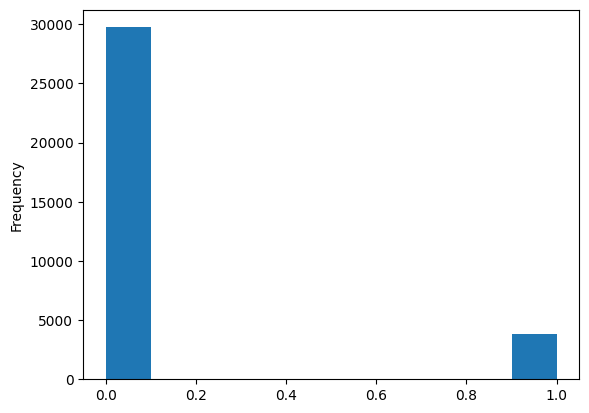

In [70]:
ewrs_df['cancer'].plot.hist()

In [33]:
ewrs_df[ewrs_df.kfold!=0].cancer.value_counts()

0    31494
1     4243
Name: cancer, dtype: int64

In [1]:
33517//(4*14)

598

## Calculate Mean/STD of the entire batch

# Check Albumentations

In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
train_kfolds = pd.read_csv('input_data/master_kfold_data.csv')

In [4]:
train_kfolds[train_kfolds.cancer==0].shape, train_kfolds[train_kfolds.cancer==1].shape

((53548, 20), (2314, 20))

In [5]:
train_kfolds.kfold.value_counts()

1    11181
4    11174
3    11171
2    11171
0    11165
Name: kfold, dtype: int64

In [6]:
train_kfolds[train_kfolds.kfold==0].shape, train_kfolds[train_kfolds.kfold!=0].shape , train_kfolds[(train_kfolds.kfold!=0) & (train_kfolds.cancer==1)].shape

((11165, 20), (44697, 20), (1852, 20))

In [7]:
44697/1852/4

6.033612311015119

In [8]:
53548/(2314)/2

11.570440795159897

In [10]:
14*2

28

In [11]:
990/10/7

14.142857142857142

In [12]:
53548/2314/4

5.785220397579948

In [9]:
train_kfolds['dump_path'] = train_kfolds.apply(lambda row : ''.join('input_data/train_crop_voilut_2048'+'/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.png'), axis=1)

In [10]:
train_kfolds[train_kfolds['cancer']==1]['dump_path'].values

array(['input_data/train_crop_voilut_2048/15268/1658071377.png',
       'input_data/train_crop_voilut_2048/53360/2297816353.png',
       'input_data/train_crop_voilut_2048/34993/646782293.png', ...,
       'input_data/train_crop_voilut_2048/21315/680205768.png',
       'input_data/train_crop_voilut_2048/25187/1207987797.png',
       'input_data/train_crop_voilut_2048/62608/1233738688.png'],
      dtype=object)

In [11]:
train_kfolds.head()['dump_path'].values

array(['input_data/train_crop_voilut_2048/14951/1296262783.png',
       'input_data/train_crop_voilut_2048/21520/1542713553.png',
       'input_data/train_crop_voilut_2048/3872/909567878.png',
       'input_data/train_crop_voilut_2048/52479/750902630.png',
       'input_data/train_crop_voilut_2048/12047/404122403.png'],
      dtype=object)

In [12]:
IMG_SIZE = (2048,1024)

TRAIN_TRANSFORM = A.Compose([
                            A.Resize(IMG_SIZE[0],IMG_SIZE[1]),
                            # A.VerticalFlip(p=0.3),
                            # A.OpticalDistortion (distort_limit=0.05, shift_limit=0.05, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1),
                            # A.GridDistortion(p=0.5) ,
                            # A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), p=1) ,
                           # A.LongestMaxSize(max_size=args.img_size, interpolation=1, p=1.0),
                            # A.CenterCrop(height=1024, width=1024, p=1.0),
                            # A.RandomBrightnessContrast(p=0.2, brightness_limit=0.2, contrast_limit=0.2),
                            # A.CoarseDropout(always_apply=False, p=1, min_holes=8, max_holes=16, min_height=10, min_width=10, max_height=30, max_width=20),
                            # A.ElasticTransform(always_apply=False, p=1, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None, approximate=False),
                            # A.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                            ToTensorV2()
                            ])


In [13]:
laod_img = cv2.imread('input_data/train_crop_voilut_2048/15268/1658071377.png')

In [14]:
laod_img = TRAIN_TRANSFORM(image=laod_img)["image"]
laod_img = laod_img.permute(1,2,0).detach().cpu().numpy()

In [15]:
laod_img.shape

(2048, 1024, 3)

In [16]:
# Convert to grayscale if necessary
# if len(laod_img.shape) > 2:
#     laod_img = laod_img[:,:,1] #np.mean(laod_img, axis=2)


In [17]:
laod_img.shape

(2048, 1024, 3)

In [18]:

# from skimage.feature import hog
# from skimage import data, exposure


# image = laod_img.copy()

# fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
#                     cells_per_block=(1, 1), visualize=True, channel_axis=-1)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# ax1.axis('off')
# ax1.imshow(image, cmap=plt.cm.gray)
# ax1.set_title('Input image')

# # Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# ax2.axis('off')
# ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
# ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [1]:
import torch

In [5]:
cc = torch.tensor([2,3])
cc1 = torch.tensor([3,3])
cc2 = torch.tensor([4,4])


In [6]:
cv1 = torch.stack([cc,cc1,cc2],dim=1)

In [9]:
cv1

tensor([[2, 3, 4],
        [3, 3, 4]])

In [13]:
cv1[:,2]

tensor([4, 4])

In [19]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

In [20]:
gray = rgb2gray(laod_img.copy())
nw_img = local_binary_pattern(gray.copy(), P=8, R=5, method='ror')
nw_img_bin = local_binary_pattern(gray.copy(), P=3, R=1, method='default')

In [21]:
gray.shape

(2048, 1024)

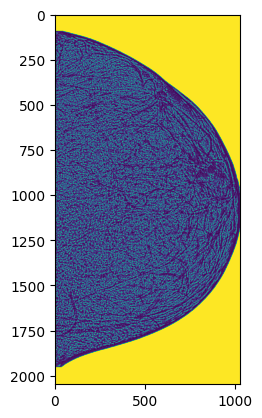

In [22]:
plt.imshow(nw_img)

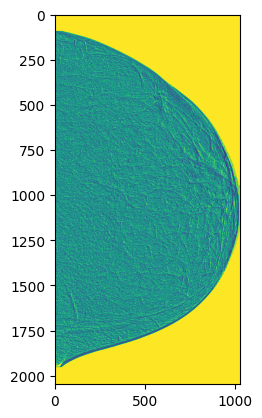

In [23]:
plt.imshow(nw_img_bin)

In [24]:
# stich_img = np.stack((laod_img, nw_img, nw_img_bin), axis=2)
stich_img = np.dstack([gray, nw_img, nw_img_bin])

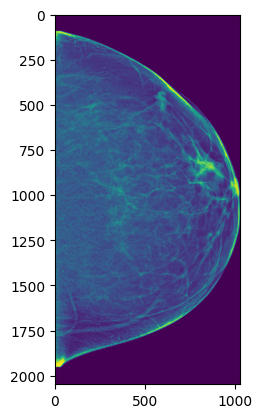

In [25]:
plt.imshow(gray)

In [26]:
stich_img.shape

(2048, 1024, 3)

In [27]:
stich_img[:,:,2].max()

7.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


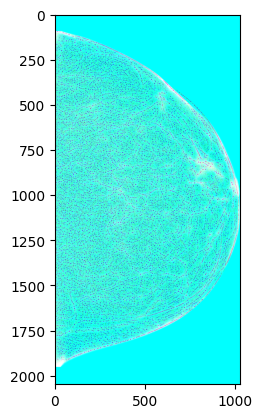

In [29]:
plt.imshow(stich_img[:,:,])

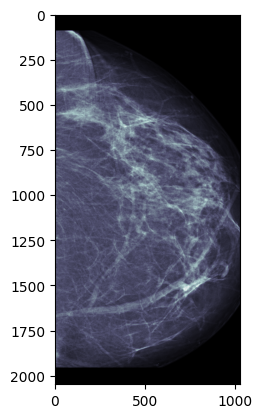

In [41]:
plt.imshow(laod_img,cmap="bone")

In [66]:
import pywt

In [69]:
original = laod_img.copy()  
print(original.shape) 
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')

# coeffs2 = pywt.dwt2(laod_img, 'db1')

# LL, (LH, HL, HH) = coeffs2

(2048, 1024)
(2048, 1024)


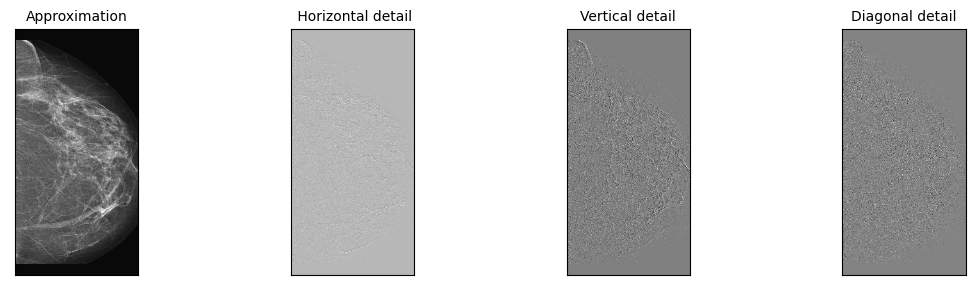

In [59]:




original = laod_img.copy()  
    
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
# coeffs2 = pywt.dwt2(original, 'db1')

LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


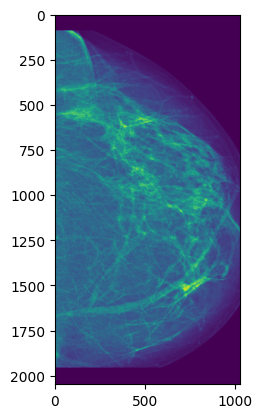

In [29]:
plt.imshow(laod_img)

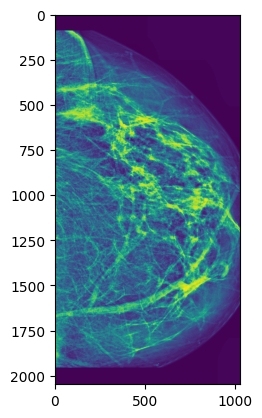

In [20]:
plt.imshow(laod_img)

In [66]:
def display_sample_image(df,cols=5,mode="train",augmentation=False):
    df_postive = df[df['cancer']==1].head(10) #.sample(n=10)
    df_neg = df[df['cancer']==0].head(10) #.sample(n=10)
    df = pd.concat([df_postive,df_neg]).reset_index()
    rows = len(df) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
    ax = ax.ravel()
    for i, row in df.iterrows():
        image = cv2.imread(row['dump_path'])
        true_label = row['cancer']
        predicted_label = "cancer" if true_label == 1 else "non-cancer"
        color = "green" if true_label == 1 else "red"
        # Albumentation
        if augmentation:
            image = TRAIN_TRANSFORM(image=image)["image"]
            image = image.permute(1,2,0)
            
        ax[i].imshow(image)
        ax[i].text( .1,.95, f"{row['image_id']}", ha='left', va='top', fontsize = 15,color = 'r')
        ax[i].set_title(predicted_label, color=color)
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.title(f"Display {mode.capitalize()} sample data")
    plt.show()
    plt.close()


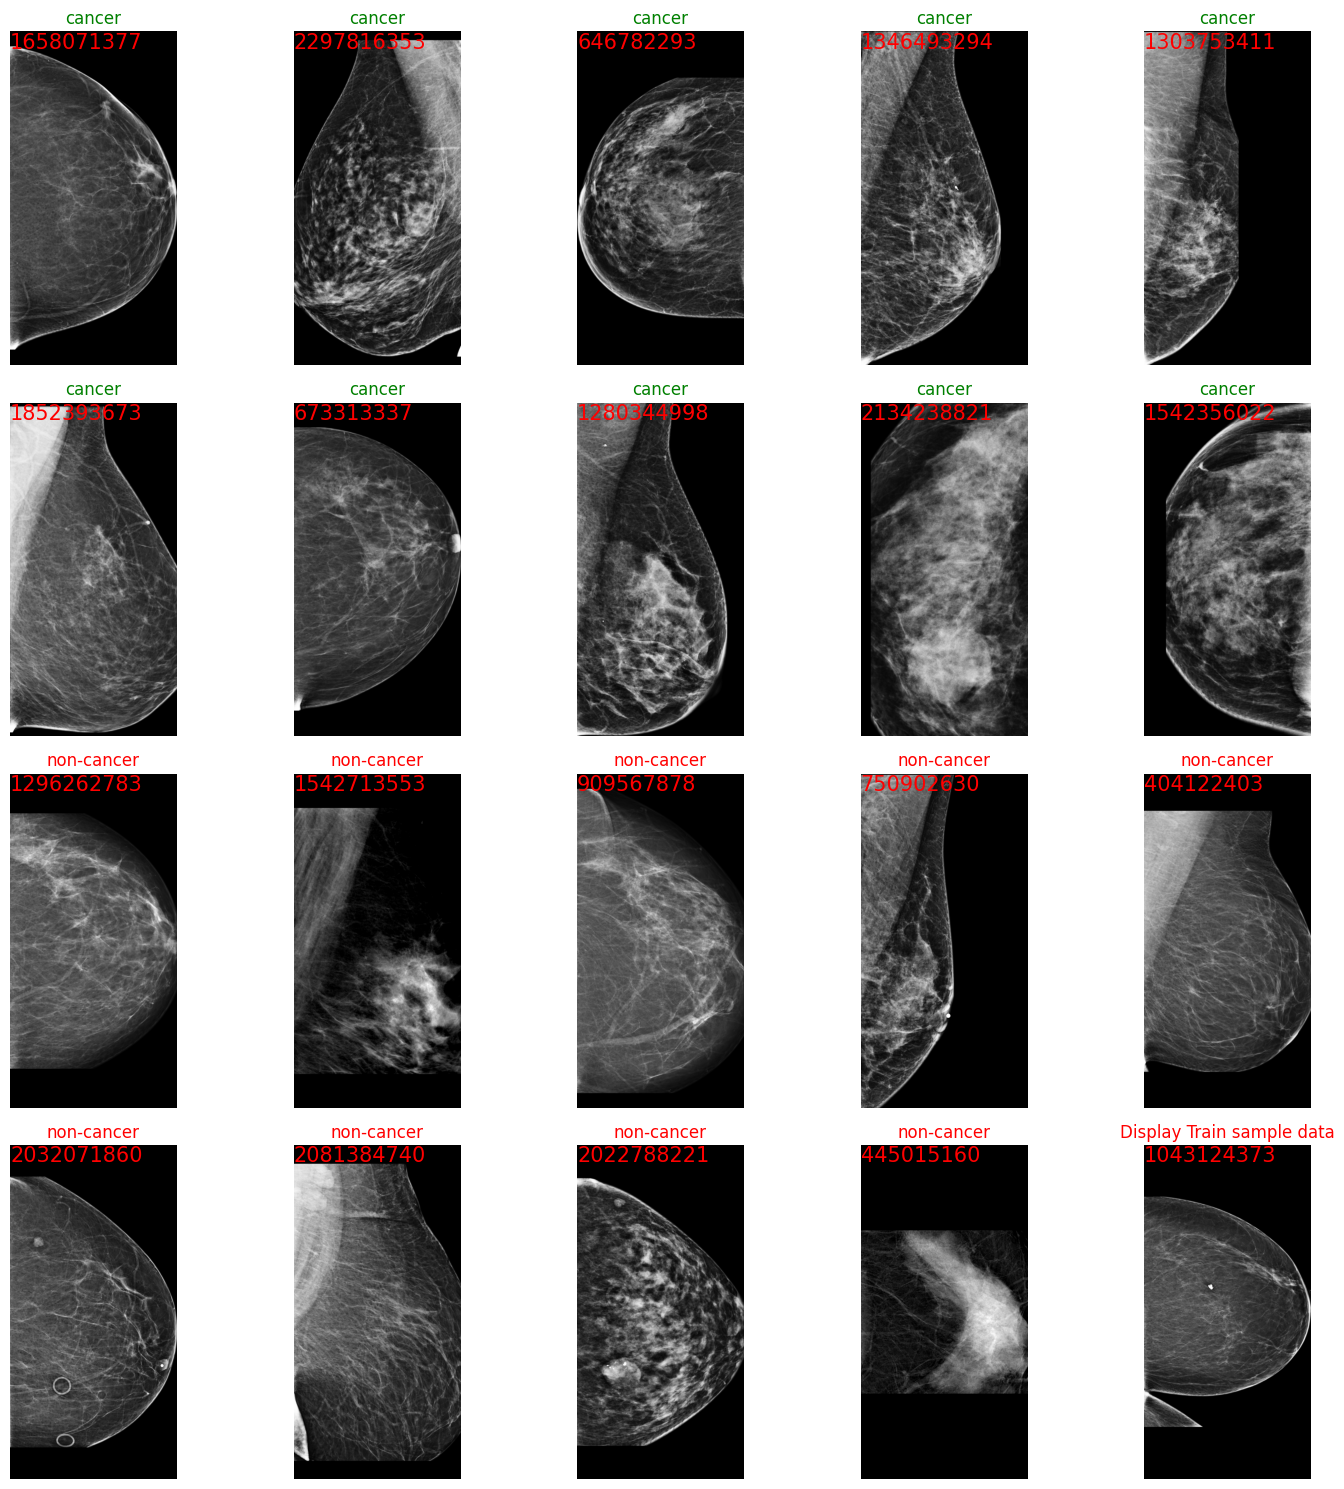

In [67]:
display_sample_image(train_kfolds,mode="train")

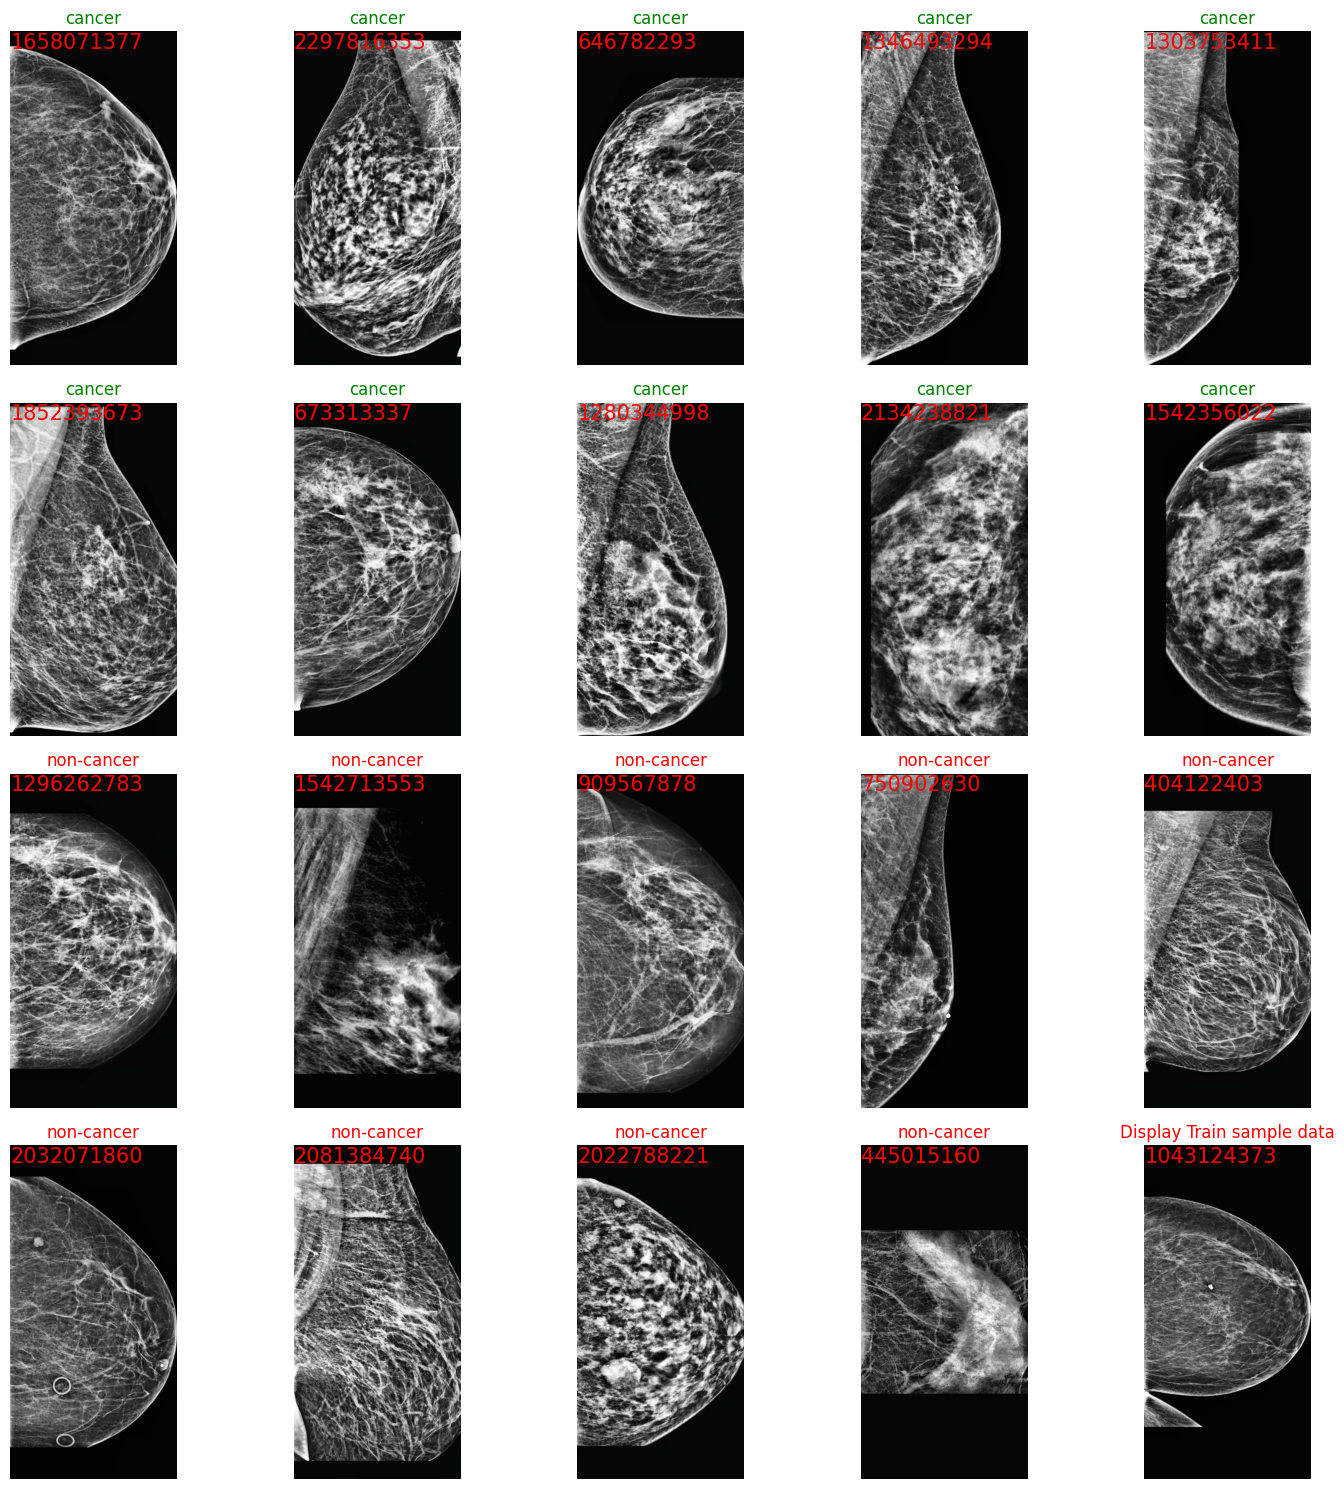

In [69]:
display_sample_image(train_kfolds,mode="train",augmentation=True)